In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import  expon, norm, gamma, beta, lognorm
from scipy.stats._continuous_distns import beta_gen, gamma_gen
from scipy import stats
from datetime import datetime, timedelta

# EDA

In [2]:
zone1 = pd.read_csv('data/out_1.csv', usecols=["Datum", "Uhrzeit", "Masse [kg]", "Geschwindigkeit [m/s]"])
zone2 = pd.read_csv('data/out_2.csv', usecols=["Date", "Uhrzeit", "m [kg]", "v [m/s]"])
zone1.columns = ["date", "time", "kg", "m/s"]
zone2.columns = ["date", "time", "kg", "m/s"]

In [3]:
pd.concat([zone1, zone2], axis=1, keys=['zone1', 'zone2']).describe()

zone1                  zone2           
                kg        m/s          kg        m/s
count    68.000000  68.000000   32.000000  32.000000
mean    628.632353   8.788235   99.250000  37.790625
std     695.884703   1.989189  104.072555   5.395778
min      12.000000   3.600000    0.000000  24.900000
25%     214.750000   7.300000   36.750000  33.200000
50%     402.500000   8.800000   58.000000  38.750000
75%     773.000000  10.125000  140.000000  41.725000
max    3104.000000  14.100000  406.000000  46.500000

In [4]:
zone1.head()

,date,time,kg,m/s
0,2019-01-01,09:00,194.0,8.4
1,2019-01-01,21:00,224.0,8.8
2,2019-01-02,14:00,3104.0,9.2
3,2019-01-04,15:00,228.0,8.0
4,2019-01-05,23:00,755.0,7.0


### NAs

In [5]:
# Check for NaN values
print(zone1.isna().sum())

# Check for zeros
print(zone1.eq(0).sum())

date    11
time    11
kg      11
m/s     11
dtype: int64
date    0
time    0
kg      0
m/s     0
dtype: int64


In [6]:
# Drop lines with only NA values
zone1 = zone1.dropna(how='all')

In [7]:
zone2.head()


,date,time,kg,m/s
0,2019-01-01,09:00,38.0,45.4
1,2019-01-03,06:00,187.0,41.6
2,2019-01-04,10:00,36.0,44.6
3,2019-01-07,14:00,6.0,41.2
4,2019-01-11,06:00,65.0,39.6


In [8]:
# Check for NaN values
print(zone2.isna().sum())

# Check for zeros
print(zone2.eq(0).sum())

date    3
time    3
kg      3
m/s     3
dtype: int64
date    0
time    0
kg      1
m/s     0
dtype: int64


In [9]:
# Drop lines with only NA values
zone2 = zone2.dropna(how='all')


In [10]:
# Set the value to the median in the row where 'kg' equals 0.0
# This rock is not removed from the data, because we do not have a lot of data and this might just have been an error in the measurement
zone2.loc[zone2['kg'] == 0.0, 'kg'] = zone2['kg'].median()

In [11]:
pd.concat([zone1, zone2], axis=1, keys=['zone1', 'zone2']).describe()

zone1                  zone2           
                kg        m/s          kg        m/s
count    68.000000  68.000000   32.000000  32.000000
mean    628.632353   8.788235  101.062500  37.790625
std     695.884703   1.989189  102.785382   5.395778
min      12.000000   3.600000    3.000000  24.900000
25%     214.750000   7.300000   37.750000  33.200000
50%     402.500000   8.800000   58.000000  38.750000
75%     773.000000  10.125000  140.000000  41.725000
max    3104.000000  14.100000  406.000000  46.500000

# Visualization

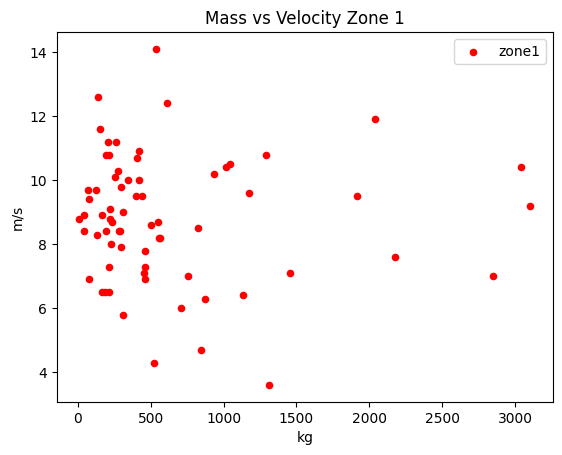

In [12]:
zone1.plot(x='kg', y='m/s', kind='scatter', c='red', label='zone1', title='Mass vs Velocity Zone 1')
plt.show()

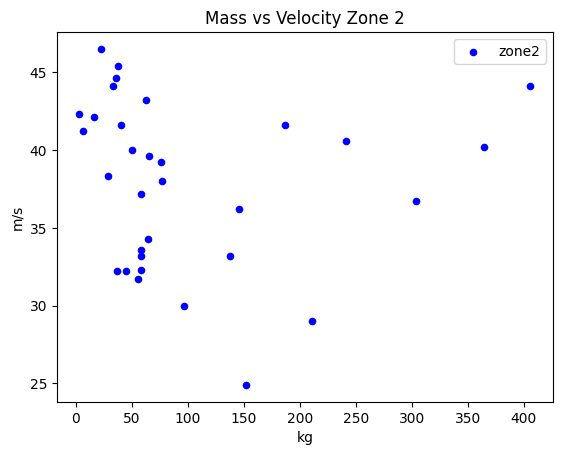

In [13]:
zone2.plot(x='kg', y='m/s', kind='scatter', c='blue', label='zone2', title='Mass vs Velocity Zone 2')
plt.show()

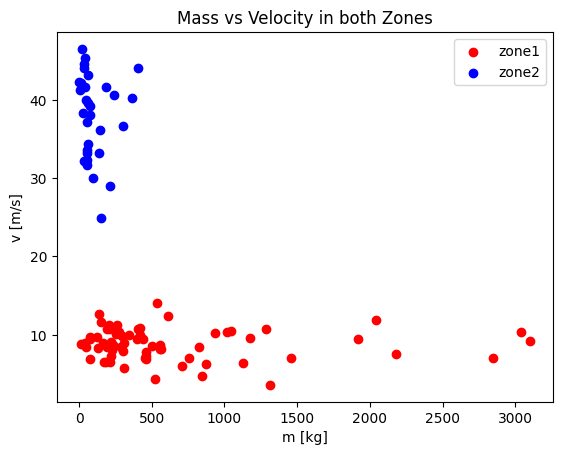

In [14]:
fig, ax = plt.subplots()
ax.scatter(zone1['kg'], zone1['m/s'], c='red', label='zone1')
ax.scatter(zone2['kg'], zone2['m/s'], c='blue', label='zone2')
ax.legend()
ax.axes.set_xlabel('m [kg]')
ax.axes.set_ylabel('v [m/s]')
plt.title('Mass vs Velocity in both Zones')
plt.show()

Zonen 1 und 2 sollten nicht gemischt werden, weil sonst sehr schwere steine generiert werden könnten die eine hohe Geschwindigkeit haben, was in den Aufzeichnungen aber nicht vorkomt (nicht gleiche Grundgesammtheit).

In [15]:
zone1['kj'] = 0.5 * zone1['kg'] * (zone1['m/s']**2) /1000
zone2['kj'] = 0.5 * zone2['kg'] * (zone2['m/s']**2) /1000

In [16]:
# Convert the 'date' and 'time' columns to datetime for zone1
zone1['datetime'] = pd.to_datetime(zone1['date'] + ' ' + zone1['time'])

# Calculate the time difference between each row and the row above, in hours then set the first row to the median of all rows
zone1['timediv h'] = (zone1['datetime'] - zone1['datetime'].shift()).fillna(pd.Timedelta(seconds=0))
zone1['timediv h'] = zone1['timediv h'].apply(lambda x: int(round(x.total_seconds() / 3600)))

# Set the first row to the median of all rows so we don't loose a value
zone1.loc[0, 'timediv h'] = zone1['timediv h'].median()

# Print the updated dataframe
print(zone1)

          date   time      kg  m/s          kj            datetime  timediv h
0   2019-01-01  09:00   194.0  8.4    6.844320 2019-01-01 09:00:00         22
1   2019-01-01  21:00   224.0  8.8    8.673280 2019-01-01 21:00:00         12
2   2019-01-02  14:00  3104.0  9.2  131.361280 2019-01-02 14:00:00         17
3   2019-01-04  15:00   228.0  8.0    7.296000 2019-01-04 15:00:00         49
4   2019-01-05  23:00   755.0  7.0   18.497500 2019-01-05 23:00:00         32
..         ...    ...     ...  ...         ...                 ...        ...
63  2019-03-18  16:00   167.0  8.9    6.614035 2019-03-18 16:00:00         28
64  2019-03-22  18:00  2847.0  7.0   69.751500 2019-03-22 18:00:00         98
65  2019-03-26  00:00    44.0  8.9    1.742620 2019-03-26 00:00:00         78
66  2019-03-26  06:00    45.0  8.4    1.587600 2019-03-26 06:00:00          6
67  2019-03-27  16:00   312.0  5.8    5.247840 2019-03-27 16:00:00         34

[68 rows x 7 columns]


In [17]:
# Convert the 'date' and 'time' columns to datetime for zone2
zone2['datetime'] = pd.to_datetime(zone2['date'] + ' ' + zone2['time'])

# Calculate the time difference between each row and the row above, in hours
zone2['timediv h'] = (zone2['datetime'] - zone2['datetime'].shift()).fillna(pd.Timedelta(seconds=0))
zone2['timediv h'] = zone2['timediv h'].apply(lambda x: int(round(x.total_seconds() / 3600)))

# Set the first row to the median of all rows so we don't loose a value
zone2.loc[0, 'timediv h'] = zone2['timediv h'].median()

# Print the updated dataframe
print(zone2)

          date   time     kg   m/s          kj            datetime  timediv h
0   2019-01-01  09:00   38.0  45.4   39.162040 2019-01-01 09:00:00       48.5
1   2019-01-03  06:00  187.0  41.6  161.807360 2019-01-03 06:00:00       45.0
2   2019-01-04  10:00   36.0  44.6   35.804880 2019-01-04 10:00:00       28.0
3   2019-01-07  14:00    6.0  41.2    5.092320 2019-01-07 14:00:00       76.0
4   2019-01-11  06:00   65.0  39.6   50.965200 2019-01-11 06:00:00       88.0
5   2019-01-11  16:00   58.0  33.2   31.964960 2019-01-11 16:00:00       10.0
6   2019-01-14  11:00  365.0  40.2  294.927300 2019-01-14 11:00:00       67.0
7   2019-01-16  02:00   22.0  46.5   23.784750 2019-01-16 02:00:00       39.0
8   2019-01-18  06:00  146.0  36.2   95.662120 2019-01-18 06:00:00       52.0
9   2019-01-19  17:00   29.0  38.3   21.269905 2019-01-19 17:00:00       35.0
10  2019-01-20  22:00   40.0  41.6   34.611200 2019-01-20 22:00:00       29.0
11  2019-01-21  11:00  304.0  36.7  204.727280 2019-01-21 11:00:

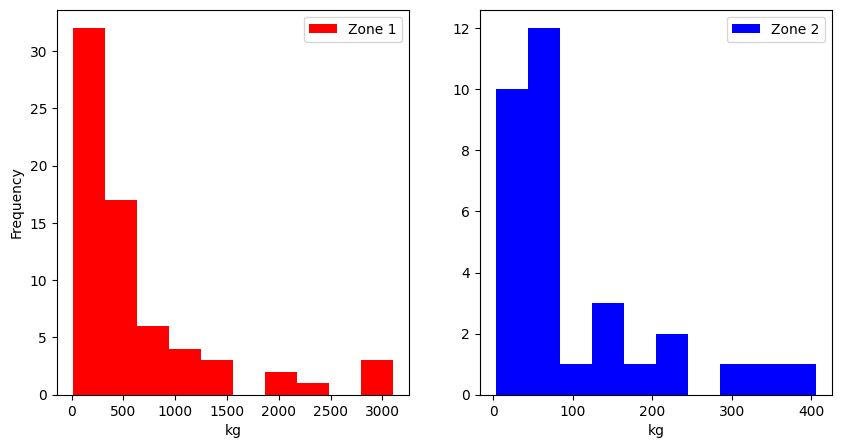

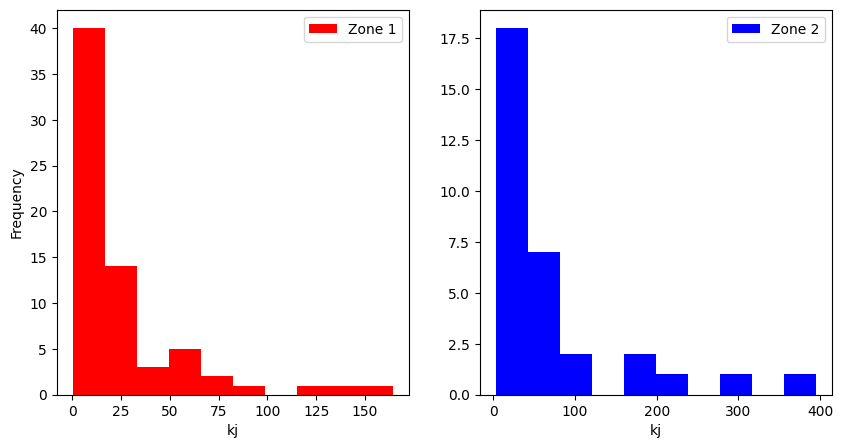

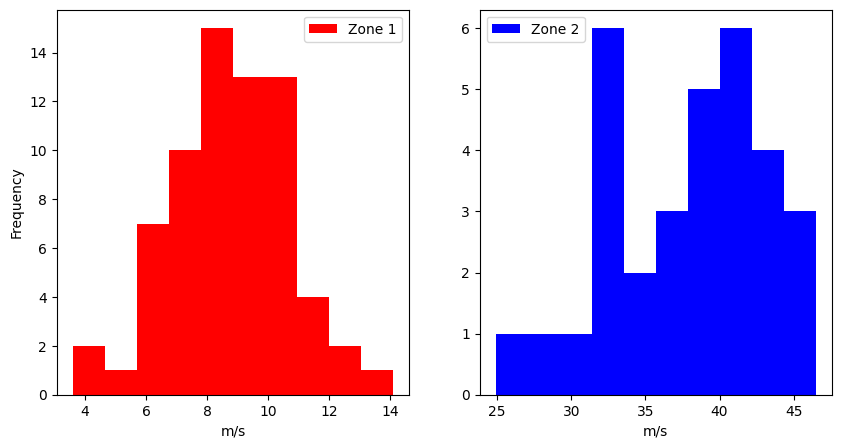

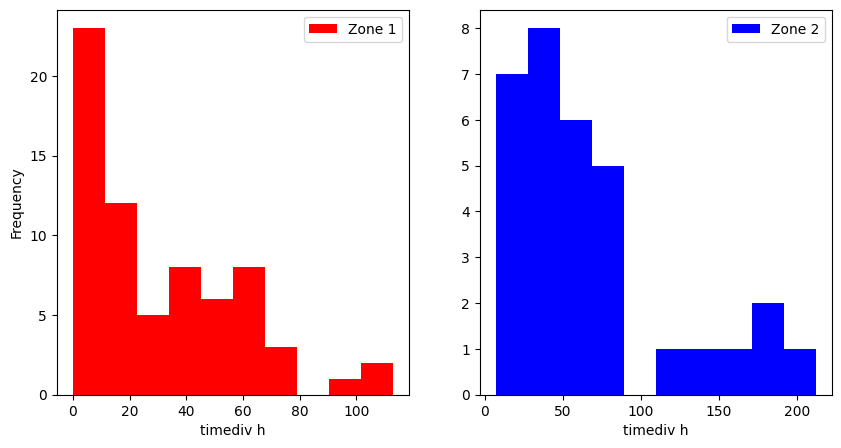

In [18]:
num_bins = 10  # Change this value to adjust the number of bins

# Plot the histograms for 'kg'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1['kg'], bins=num_bins, color='red', label='Zone 1')
ax2.hist(zone2['kg'], bins=num_bins, color='blue', label='Zone 2')

ax1.set_xlabel('kg')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('kg')
ax2.legend()
plt.show()

# Plot the histograms for 'kj'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1['kj'], bins=num_bins, color='red', label='Zone 1')
ax2.hist(zone2['kj'], bins=num_bins, color='blue', label='Zone 2')

ax1.set_xlabel('kj')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('kj')
ax2.legend()
plt.show()

# Plot the histograms for 'm/s'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1['m/s'], bins=num_bins, color='red', label='Zone 1')
ax2.hist(zone2['m/s'], bins=num_bins, color='blue', label='Zone 2')

ax1.set_xlabel('m/s')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('m/s')
ax2.legend()
plt.show()

# Plot the histograms for 'timediv h'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(zone1['timediv h'], bins=num_bins, color='red', label='Zone 1')
ax2.hist(zone2['timediv h'], bins=num_bins, color='blue', label='Zone 2')

ax1.set_xlabel('timediv h')
ax1.set_ylabel('Frequency')
ax1.legend()
ax2.set_xlabel('timediv h')
ax2.legend()
plt.show()

In [19]:
pd.concat([zone1, zone2], axis=1, keys=['zone1', 'zone2']).describe()

zone1                                          zone2             \
                kg        m/s          kj   timediv h          kg        m/s   
count    68.000000  68.000000   68.000000   68.000000   32.000000  32.000000   
mean    628.632353   8.788235   25.197761   30.426471  101.062500  37.790625   
std     695.884703   1.989189   32.704933   27.560688  102.785382   5.395778   
min      12.000000   3.600000    0.464640    0.000000    3.000000  24.900000   
25%     214.750000   7.300000    8.214900    6.000000   37.750000  33.200000   
50%     402.500000   8.800000   12.815133   22.000000   58.000000  38.750000   
75%     773.000000  10.125000   23.135955   49.000000  140.000000  41.725000   
max    3104.000000  14.100000  164.403200  113.000000  406.000000  46.500000   

                               
               kj   timediv h  
count   32.000000   32.000000  
mean    72.543707   65.765625  
std     87.452601   54.372815  
min      2.683935    7.000000  
25%     29.600176   28.750000  
50%     39.581020   50.250000  
75%     63.103560   77.250000  
max    394.796430  212.000000

In [20]:
def fit_best_distribution(data):
    # Define candidate distributions
    dist_names = [norm, lognorm, expon, gamma, beta]

    # Set up initial best parameters and likelihoods
    best_dist = None
    best_params = {}
    best_ll = 1_000_000

    # Set up a dictionary to store the log-likelihoods of each distribution
    ll_dict = {}

    # Iterate through candidate distributions and find the best fit
    for dist_name in dist_names:
        # Fit the distribution to the data using MLE
        params = dist_name.fit(data)

        # Get the negative log-likelihood of the data under the distribution
        ll = -dist_name.logpdf(data, *params).sum()

        # If the fit is better than the current best, update the best fit
        if ll < best_ll:
            best_dist = dist_name
            best_params = params
            best_ll = ll

        # Store the log-likelihood of the fit for this distribution
        ll_dict[dist_name] = ll

    # Sort the distributions by the log-likelihood of their fit
    sorted_dists = sorted(ll_dict, key=ll_dict.get)

    # Generate a list of strings describing the fit of each distribution
    dist_strings = []
    for dist_name in sorted_dists:
        if dist_name == best_dist:
            dist_strings.append(f'{dist_name} (best fit): {ll_dict[dist_name]}')
        else:
            dist_strings.append(f'{dist_name}: {ll_dict[dist_name]}')

    # Return the best distribution, its parameters, and the list of distribution fit strings
    return best_dist, best_params, dist_strings

In [21]:
z1_kg_dist, z1_kg_param, z1_kg_results = fit_best_distribution(zone1['kg'])
z1_kg_results

# TODO: Plot the distribution of the best fit with the distribution of the data or qqplot

c:\Users\bwuermli\.virtualenvs\steinschlag-t3PavukW\lib\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


['<scipy.stats._continuous_distns.beta_gen object at 0x000001EA1DACBBB0> (best fit): 499.3901307039264',
 '<scipy.stats._continuous_distns.gamma_gen object at 0x000001EA1DB0B580>: 499.5812348983543',
 '<scipy.stats._continuous_distns.expon_gen object at 0x000001EA1DB0A110>: 504.85056291042986',
 '<scipy.stats._continuous_distns.norm_gen object at 0x000001EA1DACA020>: 541.0566186379025',
 '<scipy.stats._continuous_distns.lognorm_gen object at 0x000001EA1DB309D0>: 588.3569472194833']

In [22]:
fit_best_distribution(zone2['kg']) 

(<scipy.stats._continuous_distns.beta_gen at 0x1ea1dacbbb0>,
 (0.5724005864569492,
  2.0033812481819653,
  2.9999999999999996,
  458.71842940621747),
 ['<scipy.stats._continuous_distns.beta_gen object at 0x000001EA1DACBBB0> (best fit): 165.71971224753088',
  '<scipy.stats._continuous_distns.gamma_gen object at 0x000001EA1DB0B580>: 176.68199068732446',
  '<scipy.stats._continuous_distns.expon_gen object at 0x000001EA1DB0A110>: 178.73936097578405',
  '<scipy.stats._continuous_distns.norm_gen object at 0x000001EA1DACA020>: 193.14263439814778',
  '<scipy.stats._continuous_distns.lognorm_gen object at 0x000001EA1DB309D0>: 202.06737324513256'])

In [23]:
fit_best_distribution(zone1['m/s'])

c:\Users\bwuermli\.virtualenvs\steinschlag-t3PavukW\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(<scipy.stats._continuous_distns.beta_gen at 0x1ea1dacbbb0>,
 (4529938.7775074905,
  365.72349932754736,
  -467477.1982099542,
  467523.7299867311),
 ['<scipy.stats._continuous_distns.beta_gen object at 0x000001EA1DACBBB0> (best fit): 142.69904585100392',
  '<scipy.stats._continuous_distns.norm_gen object at 0x000001EA1DACA020>: 142.74955808496244',
  '<scipy.stats._continuous_distns.lognorm_gen object at 0x000001EA1DB309D0>: 142.78018376991054',
  '<scipy.stats._continuous_distns.gamma_gen object at 0x000001EA1DB0B580>: 142.86369403078356',
  '<scipy.stats._continuous_distns.expon_gen object at 0x000001EA1DB0A110>: 179.954766089044'])

In [24]:
fit_best_distribution(zone2['m/s'])

(<scipy.stats._continuous_distns.beta_gen at 0x1ea1dacbbb0>,
 (2.135456049863241,
  1.2827668923945292,
  23.092130432299154,
  23.56888476645474),
 ['<scipy.stats._continuous_distns.beta_gen object at 0x000001EA1DACBBB0> (best fit): 96.31472557940404',
  '<scipy.stats._continuous_distns.norm_gen object at 0x000001EA1DACA020>: 98.83779420429414',
  '<scipy.stats._continuous_distns.lognorm_gen object at 0x000001EA1DB309D0>: 98.8778261365616',
  '<scipy.stats._continuous_distns.gamma_gen object at 0x000001EA1DB0B580>: 99.08821513055173',
  '<scipy.stats._continuous_distns.expon_gen object at 0x000001EA1DB0A110>: 113.8080096952003'])

In [25]:
fit_best_distribution(zone1['timediv h'])

(<scipy.stats._continuous_distns.beta_gen at 0x1ea1dacbbb0>,
 (0.6991594069187759,
  3.5897618507066174,
  -1.6403233710822477e-31,
  178.48301164629603),
 ['<scipy.stats._continuous_distns.beta_gen object at 0x000001EA1DACBBB0> (best fit): 256.59612282145633',
  '<scipy.stats._continuous_distns.gamma_gen object at 0x000001EA1DB0B580>: 267.1765496901933',
  '<scipy.stats._continuous_distns.expon_gen object at 0x000001EA1DB0A110>: 300.24128213472164',
  '<scipy.stats._continuous_distns.norm_gen object at 0x000001EA1DACA020>: 321.498655397489',
  '<scipy.stats._continuous_distns.lognorm_gen object at 0x000001EA1DB309D0>: 344.39187656468255'])

In [26]:
fit_best_distribution(zone1['timediv h'])

(<scipy.stats._continuous_distns.beta_gen at 0x1ea1dacbbb0>,
 (0.6991594069187759,
  3.5897618507066174,
  -1.6403233710822477e-31,
  178.48301164629603),
 ['<scipy.stats._continuous_distns.beta_gen object at 0x000001EA1DACBBB0> (best fit): 256.59612282145633',
  '<scipy.stats._continuous_distns.gamma_gen object at 0x000001EA1DB0B580>: 267.1765496901933',
  '<scipy.stats._continuous_distns.expon_gen object at 0x000001EA1DB0A110>: 300.24128213472164',
  '<scipy.stats._continuous_distns.norm_gen object at 0x000001EA1DACA020>: 321.498655397489',
  '<scipy.stats._continuous_distns.lognorm_gen object at 0x000001EA1DB309D0>: 344.39187656468255'])

In [27]:
# to simulate a dataframe for the next number of years it will estimate the number of events it takes and generate a frame 
def generate_simulated_data(zone_df, num_years=200):
    
    timediv_mean = zone_df['timediv h'].mean()
    
    # Calculate  the deviation
    timediv_params = gamma.fit(zone_df['timediv h'])
    kg_params = beta.fit(zone_df['kg'])
    ms_mean, ms_std = zone_df['m/s'].mean(), zone_df['m/s'].std()

    # Calculate number of observations for given number of years
    total_hours = num_years * 365.25 * 24
    num_observations = int(total_hours / timediv_mean)
    
    # Set the starting datetime to January 1st, 2000, 00:00:00
    current_datetime = datetime(2000, 1, 1, 0, 0, 0)

    # Initialize the new dataframe and generate the data
    simulated_df = pd.DataFrame(index=range(num_observations))
    simulated_df['timediv h'] = gamma(*timediv_params).rvs(size=num_observations).round(0)
    simulated_df['datetime'] = simulated_df['timediv h'].cumsum().apply(lambda x: current_datetime + timedelta(hours=x))
    simulated_df['kg'] = beta(*kg_params).rvs(size=num_observations).round(0)
    simulated_df['m/s'] = norm(ms_mean, ms_std).rvs(size=num_observations).round(0)
    simulated_df['kj'] = 0.5 * simulated_df['kg'] * (simulated_df['m/s']**2) /1000
    
    return simulated_df


In [28]:
# Generate simulated dataframes
simulated1 = generate_simulated_data(zone1)
simulated1['zone'] = 1
simulated2 = generate_simulated_data(zone2)
simulated2['zone'] = 2
simulated1.describe()
# m/s is the min 0 which is not possible

c:\Users\bwuermli\.virtualenvs\steinschlag-t3PavukW\lib\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


,timediv h,kg,m/s,kj,zone
count,57620.000000,57620.000000,57620.000000,57620.000000,57620.0
mean,27.167615,742.819351,8.780909,30.164043,1.0
std,32.900613,901.883182,2.013751,42.236357,0.0
min,0.000000,12.000000,1.000000,0.024000,1.0
25%,5.000000,58.000000,7.000000,2.080000,1.0
50%,16.000000,342.000000,9.000000,12.069000,1.0
75%,37.000000,1138.000000,10.000000,41.500750,1.0
max,478.000000,4213.000000,17.000000,475.549500,1.0


In [29]:
pd.concat([zone1, simulated1], axis=1, keys=['zone1', 'simulated1']).describe()

zone1                                       simulated1  \
                kg        m/s          kj   timediv h     timediv h   
count    68.000000  68.000000   68.000000   68.000000  57620.000000   
mean    628.632353   8.788235   25.197761   30.426471     27.167615   
std     695.884703   1.989189   32.704933   27.560688     32.900613   
min      12.000000   3.600000    0.464640    0.000000      0.000000   
25%     214.750000   7.300000    8.214900    6.000000      5.000000   
50%     402.500000   8.800000   12.815133   22.000000     16.000000   
75%     773.000000  10.125000   23.135955   49.000000     37.000000   
max    3104.000000  14.100000  164.403200  113.000000    478.000000   

                                                          
                 kg           m/s            kj     zone  
count  57620.000000  57620.000000  57620.000000  57620.0  
mean     742.819351      8.780909     30.164043      1.0  
std      901.883182      2.013751     42.236357      0.0  
min       12.000000      1.000000      0.024000      1.0  
25%       58.000000      7.000000      2.080000      1.0  
50%      342.000000      9.000000     12.069000      1.0  
75%     1138.000000     10.000000     41.500750      1.0  
max     4213.000000     17.000000    475.549500      1.0

In [30]:
simulated2.head()

,timediv h,datetime,kg,m/s,kj,zone
0,21.0,2000-01-01 21:00:00,38.0,37.0,26.0110,2
1,33.0,2000-01-03 06:00:00,190.0,36.0,123.1200,2
2,52.0,2000-01-05 10:00:00,103.0,42.0,90.8460,2
3,143.0,2000-01-11 09:00:00,38.0,34.0,21.9640,2
4,8.0,2000-01-11 17:00:00,19.0,33.0,10.3455,2


In [31]:
simulated2.tail()

,timediv h,datetime,kg,m/s,kj,zone
26653,9.0,2154-12-29 17:00:00,11.0,38.0,7.942,2
26654,20.0,2154-12-30 13:00:00,199.0,38.0,143.678,2
26655,7.0,2154-12-30 20:00:00,30.0,43.0,27.735,2
26656,97.0,2155-01-03 21:00:00,301.0,32.0,154.112,2
26657,228.0,2155-01-13 09:00:00,21.0,44.0,20.328,2


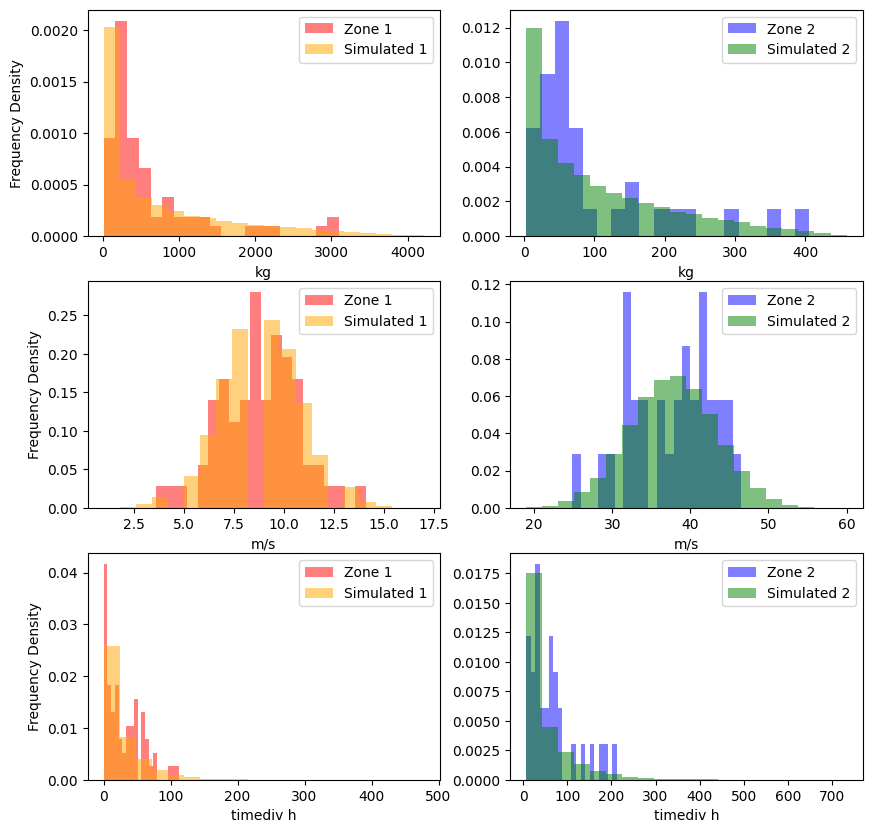

In [32]:
# Plot the histograms for 'kg', 'm/s', and 'timediv h'
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(10, 10))

# Histogram for 'kg'
ax1.hist(zone1['kg'], bins=20, color='red', alpha=0.5, label='Zone 1', density=True)
ax1.hist(simulated1['kg'], bins=20, color='orange', alpha=0.5, label='Simulated 1', density=True)
ax2.hist(zone2['kg'], bins=20, color='blue', alpha=0.5, label='Zone 2', density=True)
ax2.hist(simulated2['kg'], bins=20, color='green', alpha=0.5, label='Simulated 2', density=True)

ax1.set_xlabel('kg')
ax1.set_ylabel('Frequency Density')
ax1.legend()
ax2.set_xlabel('kg')
ax2.legend()

# Histogram for 'm/s'
ax3.hist(zone1['m/s'], bins=20, color='red', alpha=0.5, label='Zone 1', density=True)
ax3.hist(simulated1['m/s'], bins=20, color='orange', alpha=0.5, label='Simulated 1', density=True)
ax4.hist(zone2['m/s'], bins=20, color='blue', alpha=0.5, label='Zone 2', density=True)
ax4.hist(simulated2['m/s'], bins=20, color='green', alpha=0.5, label='Simulated 2', density=True)

ax3.set_xlabel('m/s')
ax3.set_ylabel('Frequency Density')
ax3.legend()
ax4.set_xlabel('m/s')
ax4.legend()

# Histogram for 'timediv h'
ax5.hist(zone1['timediv h'], bins=20, color='red', alpha=0.5, label='Zone 1', density=True)
ax5.hist(simulated1['timediv h'], bins=20, color='orange', alpha=0.5, label='Simulated 1', density=True)
ax6.hist(zone2['timediv h'], bins=20, color='blue', alpha=0.5, label='Zone 2', density=True)
ax6.hist(simulated2['timediv h'], bins=20, color='green', alpha=0.5, label='Simulated 2', density=True)

ax5.set_xlabel('timediv h')
ax5.set_ylabel('Frequency Density')
ax5.legend()
ax6.set_xlabel('timediv h')
ax6.legend()

plt.show()


In [33]:
# Determine the latest end datetime of the two dataframes
max_datetime = min(simulated1['datetime'].max(), simulated2['datetime'].max())

# Set the end datetime of both dataframes to be the same
simulated1 = simulated1[simulated1['datetime'] <= max_datetime]
simulated2 = simulated2[simulated2['datetime'] <= max_datetime]

# Merge the two dataframes together, sort by datetime, and reset the index
simulated_df = pd.concat([simulated1, simulated2])
simulated_df = simulated_df.sort_values('datetime')
simulated_df = simulated_df.reset_index(drop=True)

In [34]:
simulated_df.describe()

,timediv h,kg,m/s,kj,zone
count,76745.000000,76745.000000,76745.000000,76745.000000,76745.000000
mean,35.415206,521.451652,18.869672,46.423374,1.347358
std,46.162402,791.703029,14.276737,62.046460,0.476134
min,0.000000,3.000000,1.000000,0.024000,1.000000
25%,8.000000,37.000000,8.000000,4.175000,1.000000
50%,19.000000,156.000000,10.000000,21.112000,1.000000
75%,45.000000,635.000000,35.000000,65.024000,2.000000
max,733.000000,4213.000000,60.000000,654.673500,2.000000


In [35]:
simulated_df.tail(20)

,timediv h,datetime,kg,m/s,kj,zone
76725,88.0,2154-12-29 08:00:00,322.0,34.0,186.1160,2
76726,9.0,2154-12-29 17:00:00,11.0,38.0,7.9420,2
76727,57.0,2154-12-30 05:00:00,19.0,6.0,0.3420,1
76728,20.0,2154-12-30 13:00:00,199.0,38.0,143.6780,2
76729,7.0,2154-12-30 20:00:00,30.0,43.0,27.7350,2
76730,79.0,2155-01-02 12:00:00,67.0,8.0,2.1440,1
76731,15.0,2155-01-03 03:00:00,12.0,11.0,0.7260,1
76732,97.0,2155-01-03 21:00:00,301.0,32.0,154.1120,2
76733,44.0,2155-01-04 23:00:00,13.0,8.0,0.4160,1
76734,8.0,2155-01-05 07:00:00,853.0,10.0,42.6500,1


because the reaction time is 24h we will asume that the nets will get emptied every evening if there are stones in it.


In [36]:
# add a column that calculates the cumulative kg already in the net.

# first group the data by date
grouped_df = simulated_df.groupby(simulated_df['datetime'].dt.date)

# then calculate the cumulative sum of 'kg' within each group 
simulated_df['cumulative_kg'] = grouped_df['kg'].cumsum()
# and subtract the 'kg' valueof the new stone to get the weight in the net
simulated_df['cumulative_kg'] =  simulated_df['cumulative_kg'] - simulated_df['kg']

In [37]:
# should we disregard the rest stones of the day if the net broke trough?
# after this the road probably gets closed

# Add a new column 'breakthrough'
simulated_df['breakthrough'] = 0

# Set breakthrough to 1 where conditions are met
condition1 = (simulated_df['kj'] > 1000)
condition2 = (simulated_df['cumulative_kg'] > 2000) & (simulated_df['kj'] > 500)
simulated_df.loc[condition1 | condition2, 'breakthrough'] = 1

In [38]:
# here i look at the tail to make shure the cumulative_kg got calculated correctly.

simulated_df.tail(20)

,timediv h,datetime,kg,m/s,kj,zone,cumulative_kg,breakthrough
76725,88.0,2154-12-29 08:00:00,322.0,34.0,186.1160,2,0.0,0
76726,9.0,2154-12-29 17:00:00,11.0,38.0,7.9420,2,322.0,0
76727,57.0,2154-12-30 05:00:00,19.0,6.0,0.3420,1,0.0,0
76728,20.0,2154-12-30 13:00:00,199.0,38.0,143.6780,2,19.0,0
76729,7.0,2154-12-30 20:00:00,30.0,43.0,27.7350,2,218.0,0
76730,79.0,2155-01-02 12:00:00,67.0,8.0,2.1440,1,0.0,0
76731,15.0,2155-01-03 03:00:00,12.0,11.0,0.7260,1,0.0,0
76732,97.0,2155-01-03 21:00:00,301.0,32.0,154.1120,2,12.0,0
76733,44.0,2155-01-04 23:00:00,13.0,8.0,0.4160,1,0.0,0
76734,8.0,2155-01-05 07:00:00,853.0,10.0,42.6500,1,0.0,0


In [39]:
# Calculate the probability of a breakthrough
first_day = simulated_df['datetime'].min().date()
last_day = simulated_df['datetime'].max().date()
num_days = (last_day - first_day).days + 1

breaktroughs_prbability = (simulated_df['breakthrough'] == 1).sum() / num_days
breaktroughs_prbability

0.0

In [40]:
simulated_df['breakthrough'].value_counts()

0    76745
Name: breakthrough, dtype: int64

In [41]:
# a 5m car driving 60 will be in this zone for: 
velocity = 60 / 3.6
print('velocity:', velocity, 'm/s')
danger_time = 5 / velocity
print('danger time: ', danger_time, 's')
# with 1200 cars a day this will be that amount of seconds in danger:
total_danger_time = 1200 * danger_time
print('total danger time:', total_danger_time, 's')
# precentage of cars being in danger per day:
danger_time_proportion = total_danger_time / (24 * 60 * 60)
print('danger time proportion: ', danger_time_proportion * 100, '%')

# how likely is it that a car will be in danger and the net will break trough?
dead_probability = breaktroughs_prbability * danger_time_proportion
print('dead probability:', dead_probability * 100, '%')

velocity: 16.666666666666668 m/s
danger time:  0.3 s
total danger time: 360.0 s
danger time proportion:  0.4166666666666667 %
dead probability: 0.0 %
